# This Notebook is for analyzing bird vocalizations. The vocalizations (or segments) were collected with wireless microphones and then segmented (either manually or with AI) to represent individual calls. 
## The expectation currently is that there are 4 simultaneous birds being recorded (4 channels). A lot of the analyses is based around finding individual peculiarities that are consistent under certain conditions. Any consistent deviations (for instance, in spectral structure of a given syllable) are promising potential ways in which the birds may be communicating with each other.
## We are also interested in revealing relationships between the birds, and personalities of the individual birds, by quantifying differences in their calling behaviors.


In [1]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
# from soundsig.sound import BioSound 
# from soundsig.sound import WavFile


# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


In [2]:
base_folder = '/Users/williamwood/Documents/Sound_Localization/for_soundsep/14-38-03_18-07-2023' #7_18_23__09_29_44'
fs = 48000 # TODO find where to import fs instead of hardcoding it
# Sound_Localization/for_soundsep/7_18_23__09_29_44'

In [3]:
file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
print(file_name)

df = pd.read_csv(file_name, sep=',',header=0)        
print(f'Length of dataframe: {len(df)}')
print(f'Column names: {df.columns}')
print(f'Tags: {df["Tags"].unique()}')

/Users/williamwood/Documents/Sound_Localization/for_soundsep/14-38-03_18-07-2023/_appdata/save/segments.csv
Length of dataframe: 1250
Column names: Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags'],
      dtype='object')
Tags: ['[]' '["wingflap"]' '["tet", "feeder activates"]' '["call"]'
 '["aware of food"]' '["aggressive"]' '["what is this call"]'
 '["distance call"]' '["feeder activates"]']


### Let's rename some of the columns and create some new columns that will help us track the data
#### 'Tags' are typically the type of vocalization, but sometimes they are a note to the researcher (such as, this is interesting, look at it).

In [4]:
df['StartIndex'][0]/fs
# df['Tags'] = df['Tags'].apply(lambda x: x[2:-2]) # old technique doesn't work for all
# df.loc[df['Tags'] == '','Tags'] = 'tet' # replace empty tags with 'tet' (not perfect but ok)
df['Bird_ID'] = df['SourceName']
df['StartIndex_in_sec'] = df['StartIndex']/fs
df['EndIndex_in_sec'] = df['StopIndex']/fs

# make a new df column that is the length of the segment in seconds
df['length'] = (df['StopIndex']-df['StartIndex'])/fs

# print(df['Tags'].unique())
print(df['Bird_ID'].unique())
print(f'Columns: {df.columns}')
print(df[0:10])

['BroGre1354M' 'BluGre1214F' 'WhiWhi1541M' 'WhiWhi6607F']
Columns: Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags', 'Bird_ID', 'StartIndex_in_sec', 'EndIndex_in_sec', 'length'],
      dtype='object')
   Unnamed: 0   SourceName  SourceChannel  StartIndex  StopIndex Tags  \
0           0  BroGre1354M              0      910609     913280   []   
1           1  BluGre1214F              2      915394     917863   []   
2           2  BroGre1354M              0      938705     943378   []   
3           3  BroGre1354M              0     2093089    2097670   []   
4           4  BluGre1214F              2     2099713    2102840   []   
5           5  BluGre1214F              2     2105760    2108275   []   
6           6  WhiWhi1541M              3     2160847    2163827   []   
7           7  BroGre1354M              0     2175748    2179959   []   
8           8  BroGre1354M              0     2548038    2552297   []   
9           9  BroGre1354

## We will calculate spectral features and do some automatic identification of different call types in a bit, but first we can see how often the different birds overlap each other.
## Do some birds overlap other birds more often? Does this correlate with the relationship they have with that bird (mate vs competitor) 
## Do some birds get overlapped more often? Does this indicate they are more submissive?

In [5]:
# First we will make two new columns in the DF- whether eatch vocalization is overlapped by another, and whether it overlaps another
# We'll also make some lists of the birds that overlap and are overlapped

bird_1_overlaps = list()
bird_1_overlapped = list()
bird_2_overlaps = list()
bird_2_overlapped = list()
bird_3_overlaps = list()
bird_3_overlapped = list()
bird_4_overlaps = list()
bird_4_overlapped = list()

# add the birdname to the above lists
birdnames = [birdname for birdname in df['Bird_ID'].unique()]
bird_1_overlaps.append(birdnames[0])
bird_1_overlapped.append(birdnames[0])
bird_2_overlaps.append(birdnames[1])
bird_2_overlapped.append(birdnames[1])
bird_3_overlaps.append(birdnames[2])
bird_3_overlapped.append(birdnames[2])
bird_4_overlaps.append(birdnames[3])
bird_4_overlapped.append(birdnames[3])


df['overlap'] = ''
df['overlapped'] = ''
overlap_list =  list()
overlapped_list = list()
for i in range(len(df)):
    if i < len(df)-1:
        if df['StartIndex'][i+1] < df['StopIndex'][i]: 
            df['overlap'][i+1] = df['SourceName'][i]
            df['overlapped'][i] = df['SourceName'][i+1]
            overlapped_list.append(df['SourceName'][i])
            overlap_list.append(df['SourceName'][i+1])
            # find which bird is overlapping which to add to the bird overlap lists
            if df['SourceName'][i+1] == birdnames[0]:
                bird_1_overlaps.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[1]:
                bird_2_overlaps.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[2]:
                bird_3_overlaps.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[3]:
                bird_4_overlaps.append(df['SourceName'][i])
            else:
                print('Error: no bird name found for overlapping bird')
            if df['SourceName'][i] == birdnames[0]:
                bird_1_overlapped.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[1]:
                bird_2_overlapped.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[2]:
                bird_3_overlapped.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[3]:
                bird_4_overlapped.append(df['SourceName'][i+1])
            else:
                print('Error: no bird name found for overlapped bird')






/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_2032/3049166442.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overlap'][i+1] = df['SourceName'][i]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_2032/3049166442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overlapped'][i] = df['SourceName'][i+1]


bird_1 (BroGre1354M): Counter({'BluGre1214F': 17, 'WhiWhi1541M': 8, 'WhiWhi6607F': 3})


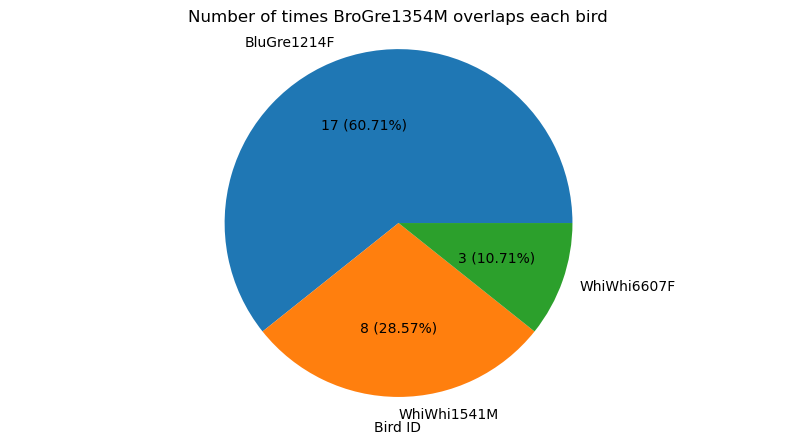

bird_2 (BluGre1214F): Counter({'WhiWhi6607F': 11, 'BroGre1354M': 10, 'WhiWhi1541M': 8})


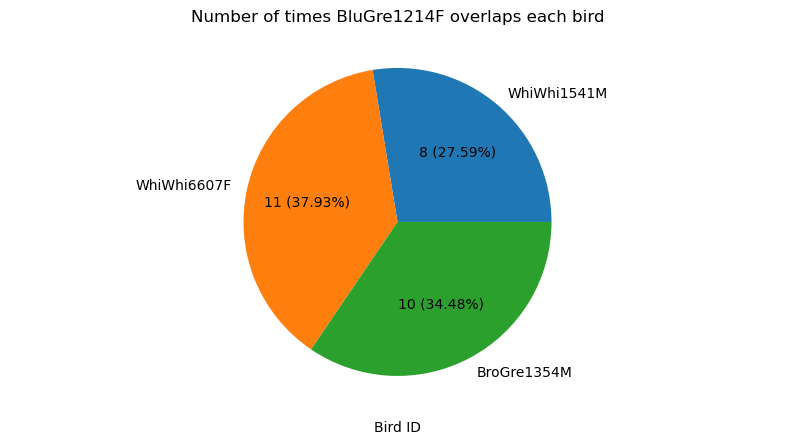

bird_3 (WhiWhi1541M): Counter({'BluGre1214F': 13, 'BroGre1354M': 11, 'WhiWhi6607F': 8})


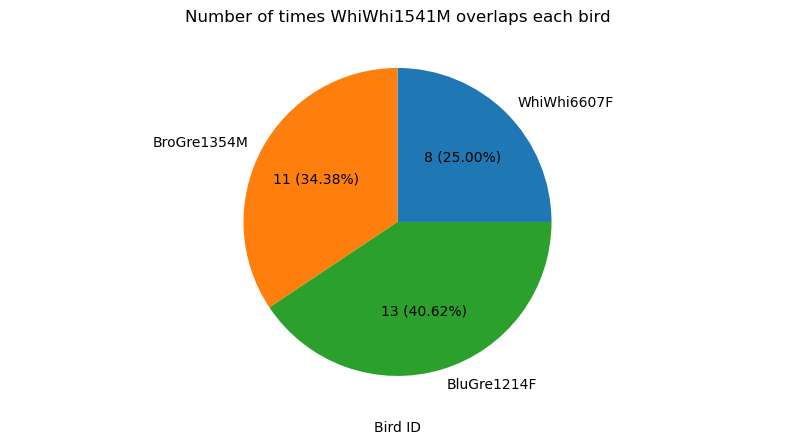

bird_4 (WhiWhi6607F): Counter({'BluGre1214F': 7, 'BroGre1354M': 6, 'WhiWhi1541M': 3})


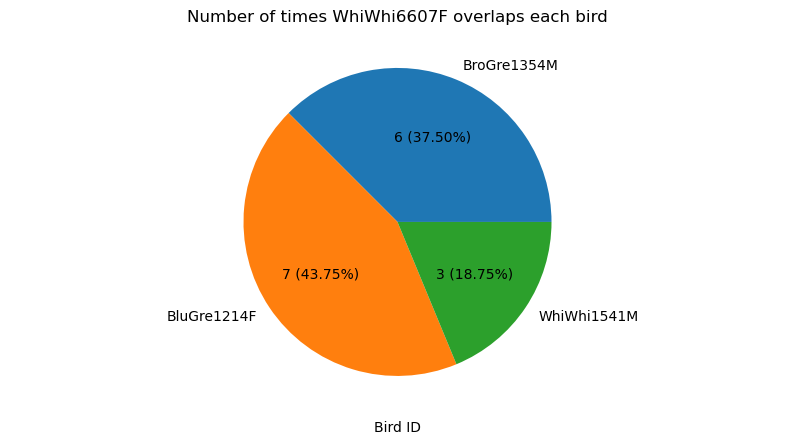

In [6]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} ({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct


print(f'bird_1 ({bird_1_overlaps[0]}): {Counter(bird_1_overlaps[1:])}')
# make a pie chart of the above data

plt.figure(figsize=(10, 5))
values = Counter(bird_1_overlaps[1:]).values()
labels = Counter(bird_1_overlaps[1:]).keys()
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.axis('equal')
plt.title(f'Number of times {bird_1_overlaps[0]} overlaps each bird')
plt.xlabel('Bird ID')
plt.show()

print(f'bird_2 ({bird_2_overlaps[0]}): {Counter(bird_2_overlaps[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_2_overlaps[1:]).values()
labels = Counter(bird_2_overlaps[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_2_overlaps[0]} overlaps each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_3 ({bird_3_overlaps[0]}): {Counter(bird_3_overlaps[1:])}')
# make a pie chart of the above data, and print the raw numbers on the pie chart
plt.figure(figsize=(10, 5))
values = Counter(bird_3_overlaps[1:]).values()
labels = Counter(bird_3_overlaps[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_3_overlaps[0]} overlaps each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_4 ({bird_4_overlaps[0]}): {Counter(bird_4_overlaps[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_4_overlaps[1:]).values()
labels = Counter(bird_4_overlaps[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_4_overlaps[0]} overlaps each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()





# print(f'bird_3 ({bird_3_overlaps[0]}): {Counter(bird_3_overlaps[1:])}')
# # make a pie chart of the above data, and print the raw numbers on the pie chart
# plt.figure(figsize=(10, 5))

# plt.pie(Counter(bird_3_overlaps[1:]).values(), labels=Counter(bird_3_overlaps[1:]).keys())


# plt.title(f'Number of times {bird_3_overlaps[0]} overlaps each bird')
# plt.xlabel('Bird ID')

# print(f'bird_4 ({bird_4_overlaps[0]}): {Counter(bird_4_overlaps[1:])}')
# # make a pie chart of the above data
# plt.figure(figsize=(10, 5))
# plt.pie(Counter(bird_4_overlaps[1:]).values(), labels=Counter(bird_4_overlaps[1:]).keys())
# plt.title(f'Number of times {bird_4_overlaps[0]} overlaps each bird')
# plt.xlabel('Bird ID')


Text(0.5, 1.0, 'Number of times each bird calls')

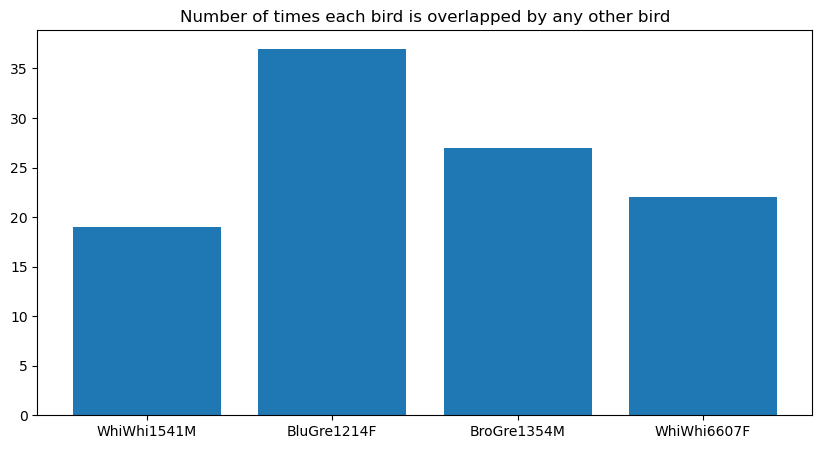

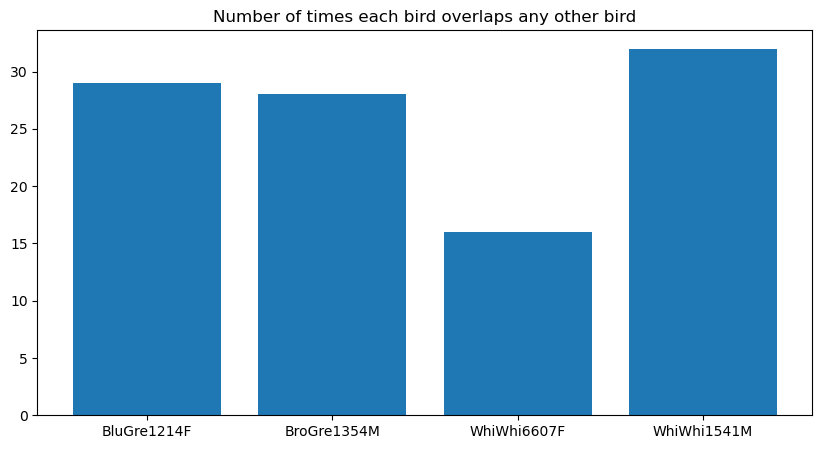

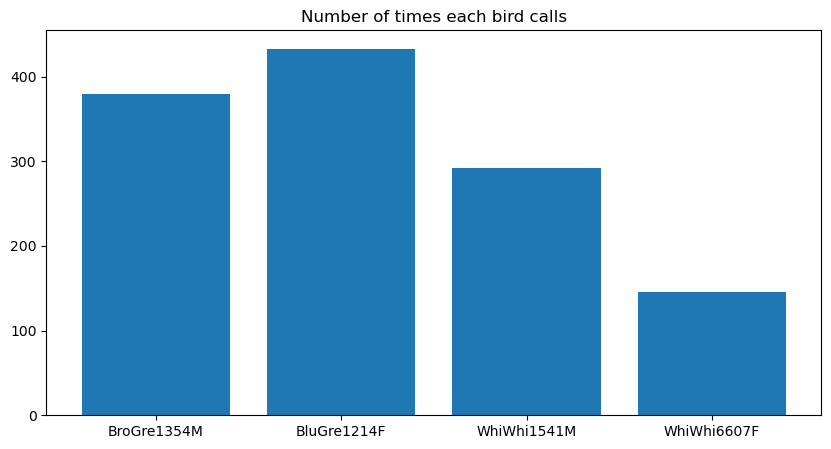

In [7]:
# number of times each bird is overlapped by any other bird, plotted as a bar graph
plt.figure(figsize=(10, 5))
values = Counter(overlapped_list).values()
labels = Counter(overlapped_list).keys()
plt.bar(labels, values)
plt.title('Number of times each bird is overlapped by any other bird')

# number of times each bird overlaps any other bird, plotted as a bar graph
plt.figure(figsize=(10, 5))
values = Counter(overlap_list).values()
labels = Counter(overlap_list).keys()
plt.bar(labels, values)
plt.title('Number of times each bird overlaps any other bird')

# number of times each bird calls, plotted as a bar graph
plt.figure(figsize=(10, 5))
values = Counter(df['Bird_ID']).values()
labels = Counter(df['Bird_ID']).keys()
plt.bar(labels, values)
plt.title('Number of times each bird calls')



bird_1 (BroGre1354M): Counter({'WhiWhi1541M': 11, 'BluGre1214F': 10, 'WhiWhi6607F': 6})


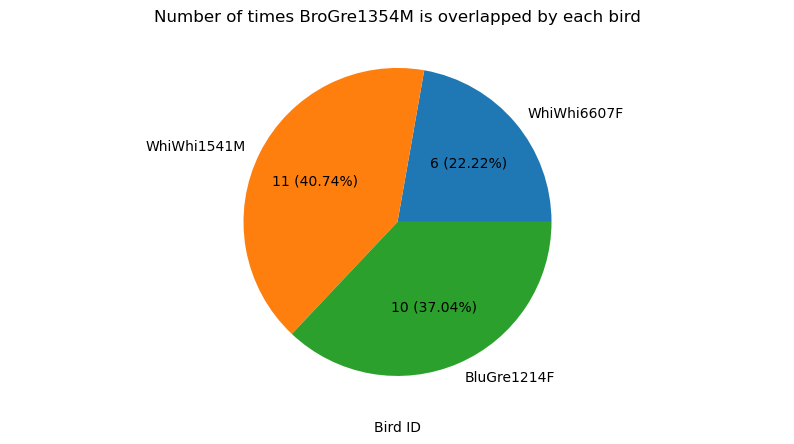

bird_2 (BluGre1214F): Counter({'BroGre1354M': 17, 'WhiWhi1541M': 13, 'WhiWhi6607F': 7})


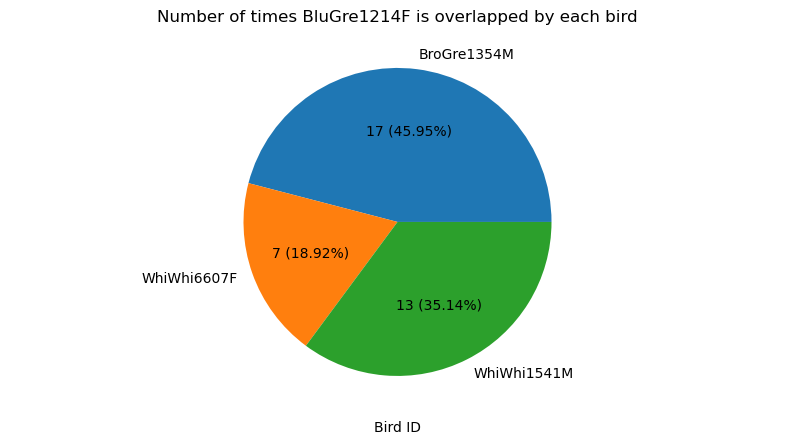

bird_3 (WhiWhi1541M): Counter({'BluGre1214F': 8, 'BroGre1354M': 8, 'WhiWhi6607F': 3})


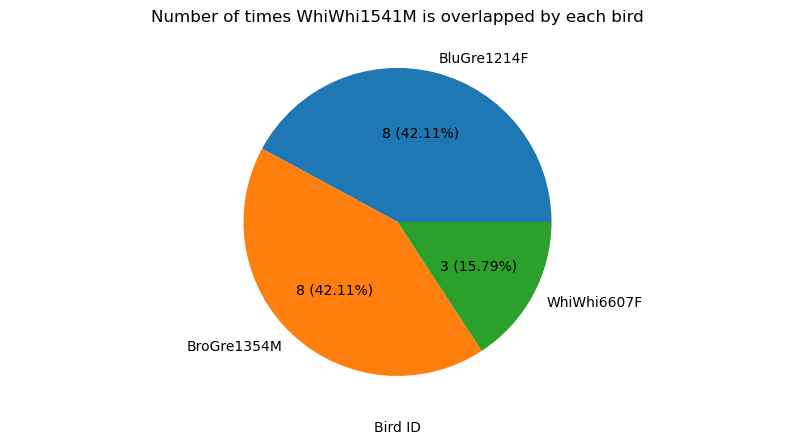

bird_4 (WhiWhi6607F): Counter({'BluGre1214F': 11, 'WhiWhi1541M': 8, 'BroGre1354M': 3})


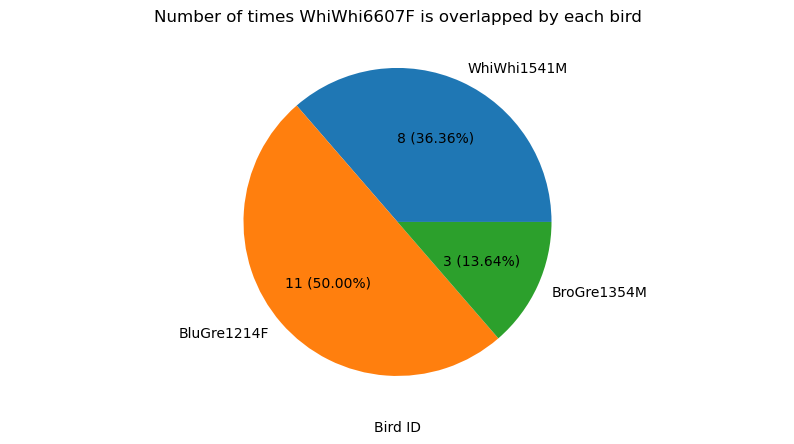

In [8]:
# Now how about how much each bird is overlapped by each bird?
print(f'bird_1 ({bird_1_overlapped[0]}): {Counter(bird_1_overlapped[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_1_overlapped[1:]).values()
labels = Counter(bird_1_overlapped[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_1_overlapped[0]} is overlapped by each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_2 ({bird_2_overlapped[0]}): {Counter(bird_2_overlapped[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_2_overlapped[1:]).values()    
labels = Counter(bird_2_overlapped[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_2_overlapped[0]} is overlapped by each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_3 ({bird_3_overlapped[0]}): {Counter(bird_3_overlapped[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_3_overlapped[1:]).values()
labels = Counter(bird_3_overlapped[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_3_overlapped[0]} is overlapped by each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_4 ({bird_4_overlapped[0]}): {Counter(bird_4_overlapped[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_4_overlapped[1:]).values()
labels = Counter(bird_4_overlapped[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_4_overlapped[0]} is overlapped by each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()


### Ok now let's look at responses instead of overlaps. Same general idea though

In [106]:
# calculate whether another segment starts within 1 second of the end of each segment
# and add this to the dataframe
df['overlap_start'] = ''
df['overlap_end'] = ''
bird_1_answered_by = list() # list of birds that respond to bird 1
bird_1_responds_to = list() # list of birds that bird 1 responds to
bird_2_answered_by = list() # list of birds that respond to bird 2
bird_2_responds_to = list() # list of birds that bird 2 responds to
bird_3_answered_by = list() # list of birds that respond to bird 3
bird_3_responds_to = list() # list of birds that bird 3 responds to
bird_4_answered_by = list() # list of birds that respond to bird 4
bird_4_responds_to = list() # list of birds that bird 4 responds to

bird_1_answered_by.append(birdnames[0])
bird_1_responds_to.append(birdnames[0])
bird_2_answered_by.append(birdnames[1])
bird_2_responds_to.append(birdnames[1])
bird_3_answered_by.append(birdnames[2])
bird_3_responds_to.append(birdnames[2])
bird_4_answered_by.append(birdnames[3])
bird_4_responds_to.append(birdnames[3])



response_interval = 1.0 # seconds # TODO make this a variable that is passed in or something
df['answered_by'] = ''
df['responds_to'] = ''
for i in range(len(df)):
    if i < len(df)-1:
        if df['StartIndex'][i+1] < ( df['StopIndex'][i] + response_interval * fs): 
            df['responds_to'][i+1] = df['SourceName'][i] # TODO make this a zip also containing the call type it responds to?
            df['answered_by'][i] = df['SourceName'][i+1] # TODO make this a zip also containing the call type that responds to it?
            # find which bird is overlapping which to add to the bird overlap lists
            if df['SourceName'][i+1] == birdnames[0]:
                bird_1_responds_to.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[1]:
                bird_2_responds_to.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[2]:
                bird_3_responds_to.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[3]:
                bird_4_responds_to.append(df['SourceName'][i])
            else:
                print('Error: no bird name found for overlapping bird')
            if df['SourceName'][i] == birdnames[0]:
                bird_1_answered_by.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[1]:
                bird_2_answered_by.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[2]:
                bird_3_answered_by.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[3]:
                bird_4_answered_by.append(df['SourceName'][i+1])
            else:
                print('Error: no bird name found for overlapped bird')

print(f'bird_1: ({bird_1_responds_to[0]}) responds to: {Counter(bird_1_responds_to[1:])}')
print(f'{bird_1_answered_by[0]}) is answered by: {Counter(bird_1_answered_by[1:])}')
print(f'bird_2: ({bird_2_responds_to[0]}) responds to: {Counter(bird_2_responds_to[1:])}')
print(f'{bird_2_answered_by[0]}) is answered by: {Counter(bird_2_answered_by[1:])}')
print(f'bird_3: ({bird_3_responds_to[0]}) responds to: {Counter(bird_3_responds_to[1:])}')
print(f'{bird_3_answered_by[0]}) is answered by: {Counter(bird_3_answered_by[1:])}')
print(f'bird_4: ({bird_4_responds_to[0]}) responds to: {Counter(bird_4_responds_to[1:])}')
print(f'{bird_4_answered_by[0]}) is answered by: {Counter(bird_4_answered_by[1:])}')


# First count the number of responses from each bird to each bird to make the weights for the social network
bird_1_response_weights = Counter(bird_1_responds_to[1:])
bird_2_response_weights = Counter(bird_2_responds_to[1:])
bird_3_response_weights = Counter(bird_3_responds_to[1:])
bird_4_response_weights = Counter(bird_4_responds_to[1:])
# Then count the number of times each bird is responded to by each bird to make the weights
bird_1_answer_weights = Counter(bird_1_answered_by[1:])
bird_2_answer_weights = Counter(bird_2_answered_by[1:])
bird_3_answer_weights = Counter(bird_3_answered_by[1:])
bird_4_answer_weights = Counter(bird_4_answered_by[1:])





bird_1: (BroGre1354M) responds to: Counter({'BroGre1354M': 114, 'BluGre1214F': 78, 'WhiWhi1541M': 40, 'WhiWhi6607F': 33})
BroGre1354M) is answered by: Counter({'BroGre1354M': 114, 'BluGre1214F': 93, 'WhiWhi6607F': 37, 'WhiWhi1541M': 28})
bird_2: (BluGre1214F) responds to: Counter({'BroGre1354M': 93, 'BluGre1214F': 93, 'WhiWhi1541M': 38, 'WhiWhi6607F': 34})
BluGre1214F) is answered by: Counter({'BluGre1214F': 93, 'BroGre1354M': 78, 'WhiWhi1541M': 45, 'WhiWhi6607F': 37})
bird_3: (WhiWhi1541M) responds to: Counter({'WhiWhi1541M': 122, 'BluGre1214F': 45, 'BroGre1354M': 28, 'WhiWhi6607F': 14})
WhiWhi1541M) is answered by: Counter({'WhiWhi1541M': 122, 'BroGre1354M': 40, 'BluGre1214F': 38, 'WhiWhi6607F': 9})
bird_4: (WhiWhi6607F) responds to: Counter({'BluGre1214F': 37, 'BroGre1354M': 37, 'WhiWhi6607F': 9, 'WhiWhi1541M': 9})
WhiWhi6607F) is answered by: Counter({'BluGre1214F': 34, 'BroGre1354M': 33, 'WhiWhi1541M': 14, 'WhiWhi6607F': 9})


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_3183/1049304193.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['responds_to'][i+1] = df['SourceName'][i] # TODO make this a zip also containing the call type it responds to?
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_3183/1049304193.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['answered_by'][i] = df['SourceName'][i+1] # TODO make this a zip also containing the call type that responds to it?


### Let's make a social netwrk graph of who responds to who


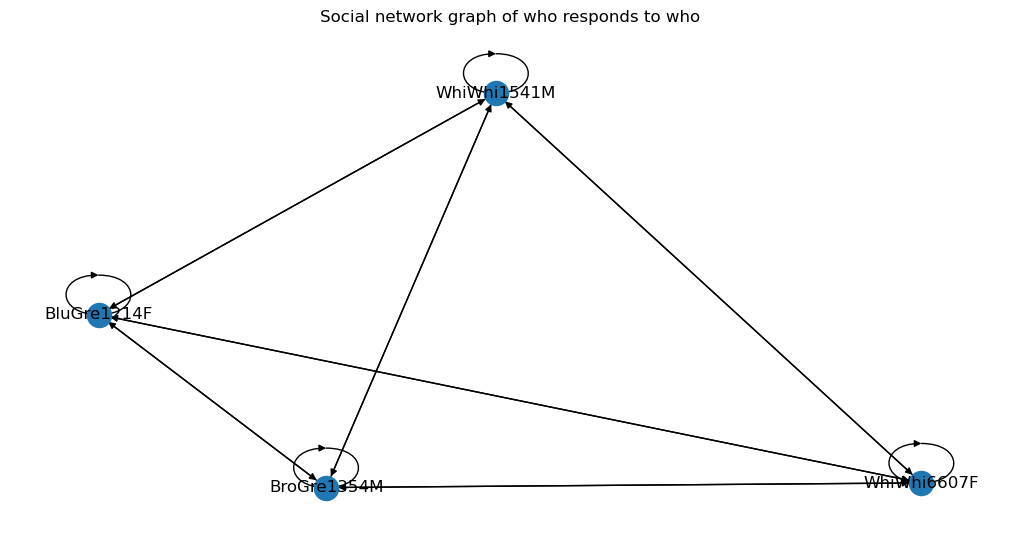

In [111]:
# We need to use a directed graph
# And make the nodes the bird names
# And make the edges the responses, weighted by the number of responses




import networkx as nx
# G = nx.Graph()
G = nx.DiGraph()
G.add_nodes_from(birdnames)

G.add_weighted_edges_from([(bird_1_responds_to[0], x,y) for x,y in bird_1_response_weights.items()])
G.add_weighted_edges_from([(bird_2_responds_to[0], x,y) for x,y in bird_2_response_weights.items()])
G.add_weighted_edges_from([(bird_3_responds_to[0], x,y) for x,y in bird_3_response_weights.items()])
G.add_weighted_edges_from([(bird_4_responds_to[0], x,y) for x,y in bird_4_response_weights.items()])
G.add_weighted_edges_from([(x, bird_1_answered_by[0],y) for x,y in bird_1_answer_weights.items()])
G.add_weighted_edges_from([(x, bird_2_answered_by[0],y) for x,y in bird_2_answer_weights.items()])
G.add_weighted_edges_from([(x, bird_3_answered_by[0],y) for x,y in bird_3_answer_weights.items()])
G.add_weighted_edges_from([(x, bird_4_answered_by[0],y) for x,y in bird_4_answer_weights.items()])




# Now plot the graph
plt.figure(figsize=(10, 5))
nx.draw(G, with_labels=True)
plt.title('Social network graph of who responds to who')
plt.show()



## Ok Now I want to take a look at some spectral features. I want to start by trying to cluster the segments based on spectral-temporal features.

In [16]:
# Save the df as a csv and a pickle file
df.to_csv(os.path.join(base_folder,'_appdata','save','call_and_response_df.csv'))

In [ ]:
|